In [1]:
export = False

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import InsectDatamodule
import numpy as np
import pandas as pd
import torchaudio
import torch
import IPython.display as ipd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats

In [3]:
def save_or_show(object, object_type, file_name, export = False):

    figure_path = "../LaTeX/figures/"
    table_path = "../LaTeX/tables/"

    if object_type == 'figure':
        
        if export:
            plt.savefig(f'{figure_path}{file_name}.pdf')
            plt.close()

        else:
            plt.show()

    elif object_type == 'table':
        if export:
            with open(f'{table_path}{file_name}.tex', 'w') as f:
                f.write(object)

        else:
            print(object)
    
    else:
        print("Invalid object_type")

In [88]:
# loading datamodule
datamodule = InsectDatamodule(csv_paths=['../data/Cicadidae.csv', '../data/Orthoptera.csv'], batch_size=10)
train_dataloader = datamodule.train_dataloader()
predict_dataloader = datamodule.predict_dataloader()

# loading metadata
metadata = train_dataloader.dataset.get_metadata()

# Loading the evaluation data
eval_csv_path = "../logs/main_run/evaluation/eval_summary.csv"
eval_data_raw = pd.read_csv(eval_csv_path)

In [5]:
# Set global parameters for axis labels and tick sizes
plt.rcParams['axes.labelsize'] = 18  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 12  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Adjust the size of the y-axis tick labels
plt.rcParams['axes.titlesize'] = 20  # Adjust the size of the title
# adjust size of ax.text to 20


# plt.rcParams['axes.titleweight'] = 'bold' # Make the title bold

Precision and recall

https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

 # F1 score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

## Plotting the Visualization of the Transformation

In [6]:
def normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def plot_transformation(path: str,
            index: int,
            n_fft: int, 
            top_db: int | None, 
            n_mels: int, 
            pad_length: int = 0, 
            show_audiosample: bool = False, 
            show_waveform: bool = False
            ):

    # loading the sample
    waveform, samplerate = train_dataloader.dataset.load_sample(path)

    # displaying the audio sample if true
    if show_audiosample:
        ipd.display(ipd.Audio(waveform.numpy()[0], rate=samplerate))


    # zero padding the waveform if needed
    if pad_length > 0:

        pad_samples = int(pad_length * samplerate)
        waveform = torch.nn.functional.pad(waveform, pad=(pad_samples, 0, 0, 0))


    # Displaying Waveform if true
    if show_waveform:

        time = np.arange(0, len(waveform[0])) / samplerate

        plt.plot(time, waveform[0, :])
        plt.title('Waveform')
        plt.xlabel('Time (s)')
        plt.show()

    # creating the mel spectrogram
    mel = torchaudio.transforms.MelSpectrogram(n_fft=n_fft, 
                                            hop_length=int(n_fft/2), 
                                            win_length=n_fft, 
                                            n_mels=n_mels
                                            )(waveform)

    # transforming the mel spectrogram with amplitude to db
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(mel)

    # normalizing the transformed mel spectrogram
    mel_db_norm = normalize(mel_db)

    # creating the spectrogram
    spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, 
                                            hop_length=int(n_fft/2), 
                                            win_length=n_fft
                                            )(waveform)

    # transforming the spectrogram with amplitude to db
    spec_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)

    # normalizing the transformed spectrogram
    spec_db_norm = normalize(spec_db)

    #setting up the plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # plotting subplots
    ax[0].imshow(spec_db_norm.numpy().squeeze(), origin='lower', aspect='auto')
    ax[0].set_title('Spectrogram')
    fig.colorbar(ax[0].imshow(spec_db_norm.numpy().squeeze(), origin='lower', aspect='auto'), ax=ax[0])

    ax[1].imshow(mel_db_norm.numpy().squeeze(), origin='lower', aspect='auto')
    ax[1].set_title('Mel spectrogram')
    fig.colorbar(ax[1].imshow(mel_db_norm.numpy().squeeze(), origin='lower', aspect='auto'), ax=ax[1])

    # creating a legend:
    text = f'sample_index: {index}, n_fft: {n_fft}, n_mels: {n_mels}, top_db: {top_db}'

    # displaying the plot
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # adjust the bottom margin
    # plt.text(0.02, 0.1, text, ha='left', va='top', transform=fig.transFigure)
    
    return fig

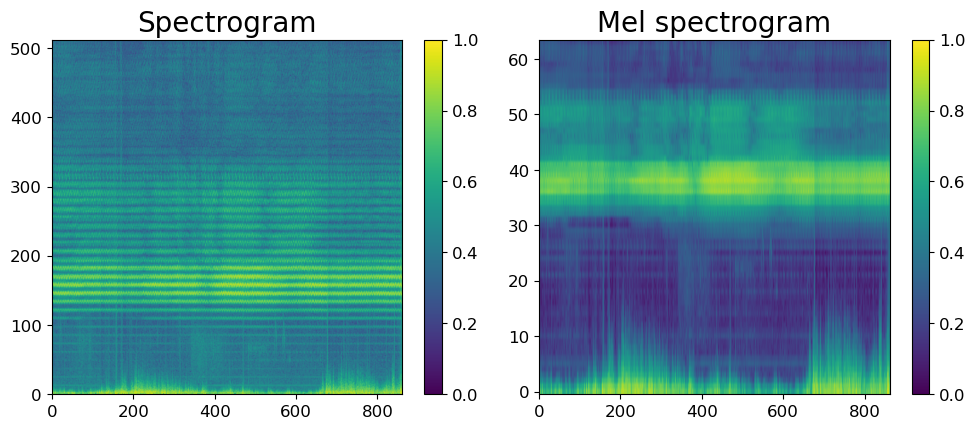

In [7]:
file_name = 'compare_spectrogram'
object_type = 'figure'

# setting up the parameters
index=26
n_fft = 1024
n_mels = 64
top_db = None
pad_length = 0
show_audiosample = False
show_waveform = False

path = metadata['path'][index]

fig = plot_transformation(path=path,
        index=index,
        n_fft=n_fft, 
        top_db=top_db, 
        n_mels=n_mels, 
        pad_length=pad_length, 
        show_audiosample=show_audiosample, 
        show_waveform=show_waveform)

save_or_show(fig, object_type, file_name, export)

## Plotting  Visualizations for best Model

In [8]:
path_best_model = '../logs/main_run/mel064_nblock4_lr0.001_ks5'

In [9]:
def get_ytrue_yhat(model_path: str, data_set_selection: list = ["test"]):

    path = f'{model_path}/predictions.csv'
    data = pd.read_csv(path)

    filtered_data = data[data['data_set'].isin(data_set_selection)]

    y_true = filtered_data['class_ID']
    y_pred = filtered_data['class_ID_pred']

    return y_true, y_pred

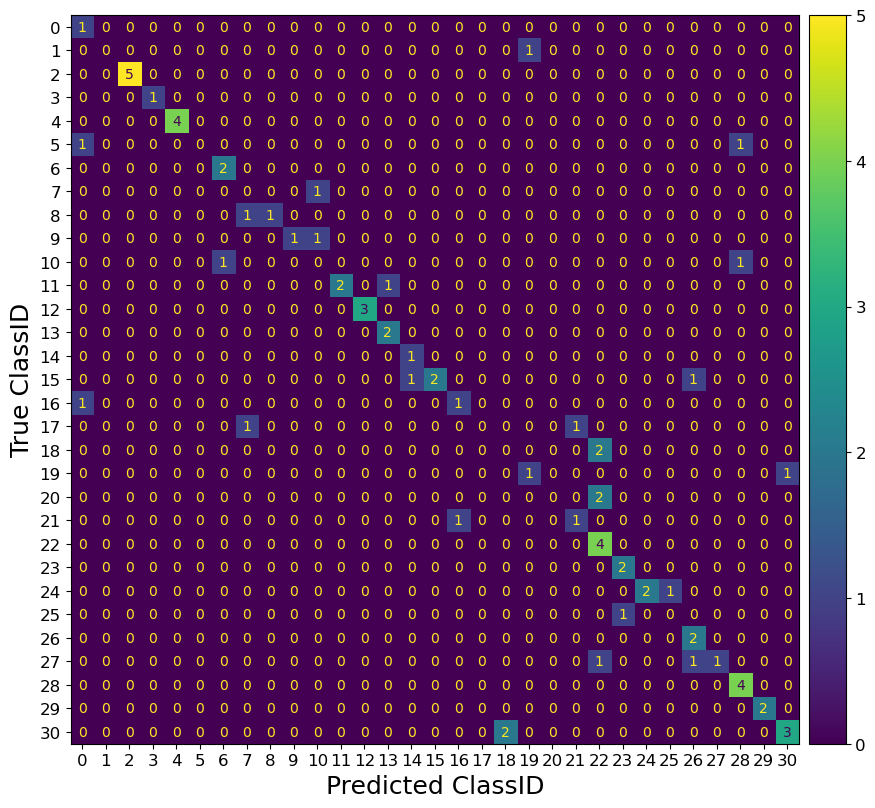

In [10]:
file_name = 'confusion_matrix_best'
object_type = 'figure'


y_true, y_pred = get_ytrue_yhat(path_best_model)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, colorbar=False)

# Label the axes
ax.set_xlabel('Predicted ClassID')
ax.set_ylabel('True ClassID')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)

save_or_show(fig, object_type, file_name, export)

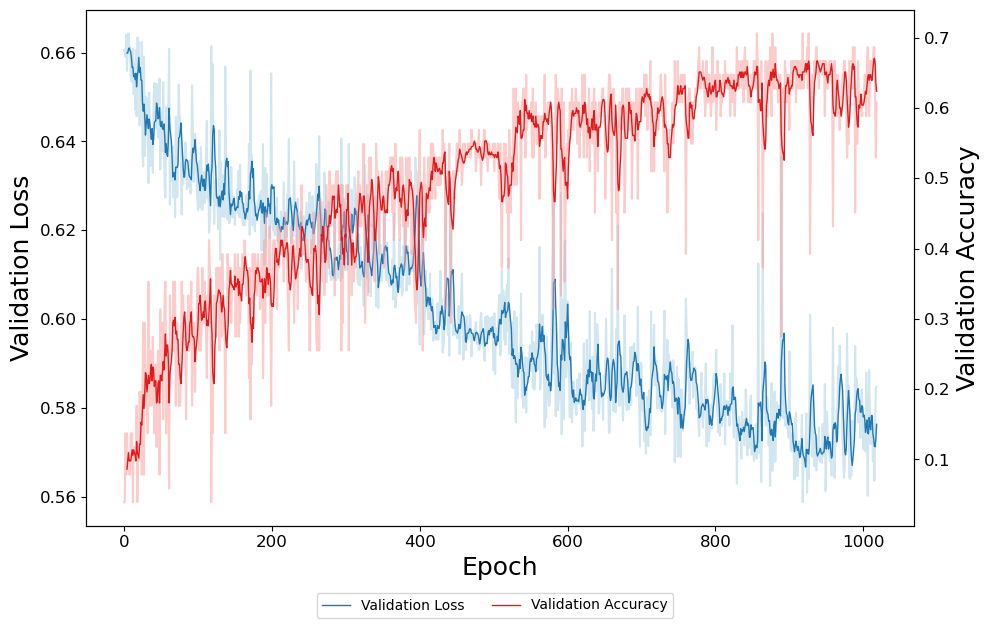

In [87]:
file_name = 'loss_acc_best'
object_type = 'figure'

def smooth_data(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

path = f'{path_best_model}/metrics.csv'
metrics_best = pd.read_csv(path)

validation_data = metrics_best[~metrics_best['val_loss'].isnull()]

# Smooth the data
smoothed_val_loss = smooth_data(validation_data['val_loss'])
smoothed_val_acc = smooth_data(validation_data['val_acc'])

# Adjust the epoch range to match the length of the smoothed data
epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot unsmoothed val_loss on the primary y-axis
ax1.plot(validation_data['epoch'], validation_data['val_loss'], color='#A6CEE3', label='', linewidth=1.5, alpha=0.5)
# Plot smoothed val_loss on the primary y-axis
ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.tick_params(axis='y')

# Create a secondary y-axis to plot val_acc
ax2 = ax1.twinx()
# Plot unsmoothed val_acc on the secondary y-axis
ax2.plot(validation_data['epoch'], validation_data['val_acc'], color='#FB9A99', label='', linewidth=1.5, alpha=0.5)
# Plot smoothed val_acc on the secondary y-axis
ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=1)
ax2.set_ylabel('Validation Accuracy')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

fig.tight_layout()  # Adjust layout to fit everything

save_or_show(fig, object_type, file_name, export)

## Visualizing the Hyperparameter Tuning of the Model

In [11]:
file_name = 'hyperparameters_results'
object_type = 'table'

eval_data = eval_data_raw[['n_mels', 'n_res_blocks', 'learning_rate', 'kernel_size', 'num_trainable_params', 'trained_epochs', 'accuracy', 'f1']]
eval_data.loc[:, 'n_mels'] = eval_data['n_mels'].fillna(-1).astype(int)
eval_data = eval_data.sort_values(by='accuracy', ascending=False)

# Formatting the DataFrame
eval_data['n_mels'] = eval_data['n_mels'].apply(lambda x: f"{x:.0f}")
eval_data['learning_rate'] = eval_data['learning_rate'].apply(lambda x: f"{x:.3g}")
eval_data['accuracy'] = eval_data['accuracy'].apply(lambda x: f"{x:.3f}")
eval_data['num_trainable_params'] = eval_data['num_trainable_params'].apply(lambda x: f"{int(x):,}")
eval_data['f1'] = eval_data['f1'].apply(lambda x: f"{x:.3f}")

# Convert DataFrame to LaTeX table
latex_table = eval_data.to_latex(
    index=False, 
    column_format="rrrrrrrr"
)

# Manually replace the header row to make it bold
old_header = "n_mels & n_res_blocks & learning_rate & kernel_size & num_trainable_params & trained_epochs & accuracy & f1 \\"
new_header = "\\textbf{n\\_mels} & \\textbf{res blocks} & \\textbf{learning rate} & \\textbf{kernel size}& \\textbf{parameters} & \\textbf{epochs} & \\textbf{accuracy} & \\textbf{F1} \\"
latex_table = latex_table.replace(old_header, new_header)

save_or_show(latex_table, object_type, file_name, export)

\begin{tabular}{rrrrrrrr}
\toprule
\textbf{n\_mels} & \textbf{res blocks} & \textbf{learning rate} & \textbf{kernel size}& \textbf{parameters} & \textbf{epochs} & \textbf{accuracy} & \textbf{F1} \\
\midrule
64 & 4 & 0.001 & 5 & 832,912 & 1018 & 0.649 & 0.546 \\
64 & 3 & 0.001 & 5 & 207,376 & 505 & 0.608 & 0.471 \\
-1 & 2 & 0.001 & 5 & 50,256 & 640 & 0.608 & 0.422 \\
-1 & 3 & 0.0001 & 3 & 78,224 & 897 & 0.581 & 0.496 \\
-1 & 2 & 0.001 & 3 & 19,408 & 469 & 0.568 & 0.408 \\
-1 & 4 & 0.0001 & 3 & 310,544 & 891 & 0.568 & 0.480 \\
-1 & 3 & 0.0001 & 7 & 401,104 & 760 & 0.568 & 0.450 \\
-1 & 4 & 0.0001 & 5 & 832,912 & 672 & 0.554 & 0.414 \\
64 & 4 & 0.0001 & 5 & 832,912 & 371 & 0.554 & 0.446 \\
64 & 3 & 0.001 & 7 & 401,104 & 350 & 0.541 & 0.395 \\
-1 & 2 & 0.0001 & 7 & 96,528 & 1198 & 0.541 & 0.429 \\
64 & 3 & 0.0001 & 7 & 401,104 & 536 & 0.541 & 0.439 \\
64 & 3 & 0.0001 & 3 & 78,224 & 1115 & 0.541 & 0.424 \\
-1 & 3 & 0.001 & 5 & 207,376 & 394 & 0.527 & 0.429 \\
-1 & 3 & 0.001 & 3 & 78,224 & 4

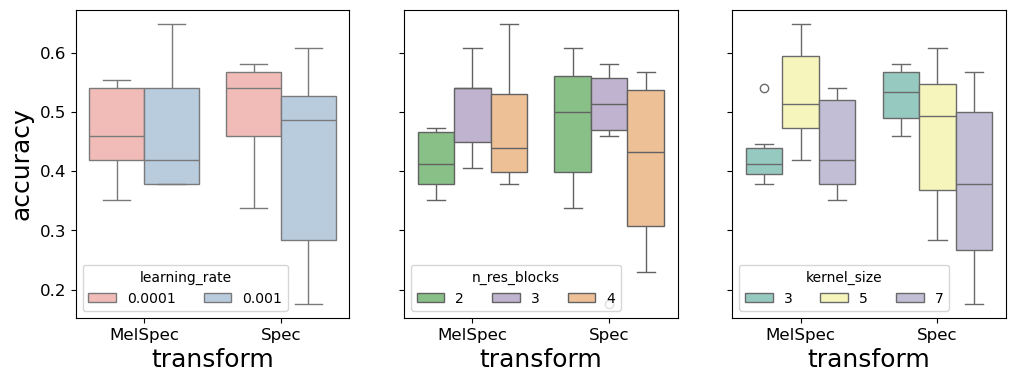

In [12]:
file_name = 'hyperparameters_boxplot'
object_type = 'figure'

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for i, (hp, cmap) in enumerate(zip(
        ['learning_rate', 'n_res_blocks', 'kernel_size'],
        ['Pastel1', 'Accent', 'Set3'])):
    ax = axes[i]
    sns.boxplot(
        data=eval_data_raw,
        x='transform',
        y='accuracy',
        palette=cmap,
        hue=hp,
        ax=ax)

    sns.move_legend(ax, 'lower left', ncols=3)

    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

save_or_show(fig, object_type, file_name, export)

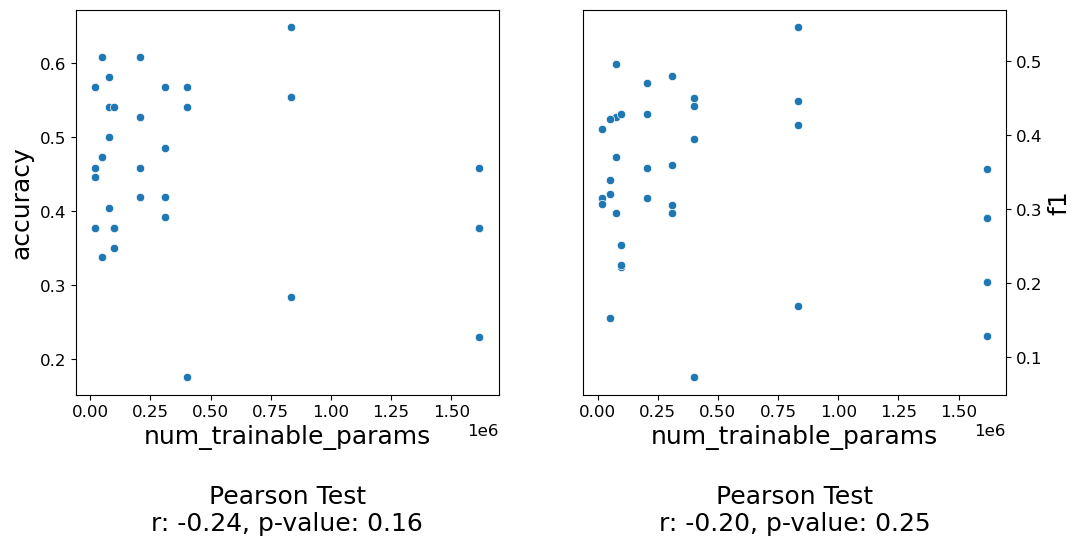

In [36]:
file_name = 'hyperparameters_scatterplot'
object_type = 'figure'

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for i, metric in enumerate(['accuracy', 'f1']):

    pearson_corr, p_value = stats.pearsonr(eval_data_raw[metric], eval_data_raw['num_trainable_params'])

    ax = axes[i]
    sns.scatterplot(
        data=eval_data_raw,
        x='num_trainable_params',
        y=metric,
        # hue='transform',
        # palette='viridis',
        ax=ax)
    
    if i > 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
    
    ax.text(0.5, -0.3, f'Pearson Test\nr: {pearson_corr:.2f}, p-value: {p_value:.2f}',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

    # sns.move_legend(ax, 'right', ncols=3)

save_or_show(fig, object_type, file_name, export)

## creating a table showing the label and names of the insects

In [15]:
file_name = 'ClassID_legend'
object_type = 'table'

unique_class_id = metadata[['class_id', 'species']].drop_duplicates(subset=['class_id']).sort_values(by='class_id')

# Split data into two parts
half = len(unique_class_id) // 2 + len(unique_class_id) % 2
first_half = unique_class_id.iloc[:half].reset_index(drop=True)
second_half = unique_class_id.iloc[half:].reset_index(drop=True)

# Concatenate first half and second half side by side
concatenated = pd.concat([first_half, second_half], axis=1)

# Adjust column names for LaTeX output
concatenated.columns = ['ClassID', 'Species', 'ClassID', 'Species']

# Convert to LaTeX
latex_table = concatenated.to_latex(
    index=False, 
    column_format="rlrl",
    header=True
)


save_or_show(latex_table, object_type, file_name, export)

\begin{tabular}{rlrl}
\toprule
ClassID & Species & ClassID & Species \\
\midrule
0 & Azanicadazuluensis & 16 & Platypleurachalybaea \\
1 & Brevisianabrevis & 17 & Platypleuradeusta \\
2 & Chorthippusbiguttulus & 18 & Platypleuradivisa \\
3 & Chorthippusbrunneus & 19 & Platypleurahaglundi \\
4 & Grylluscampestris & 20 & Platypleurahirtipennis \\
5 & Kikihiamuta & 21 & Platypleuraintercapedinis \\
6 & Myopsaltaleona & 22 & Platypleuraplumosa \\
7 & Myopsaltalongicauda & 23 & Platypleurasp04 \\
8 & Myopsaltamackinlayi & 24 & Platypleurasp10 \\
9 & Myopsaltamelanobasis & 25 & Platypleurasp11cfhirtipennis \\
10 & Myopsaltaxerograsidia & 26 & Platypleurasp12cfhirtipennis \\
11 & Nemobiussylvestris & 27 & Platypleurasp13 \\
12 & Oecanthuspellucens & 28 & Pseudochorthippusparallelus \\
13 & Pholidopteragriseoaptera & 29 & Pycnasemiclara \\
14 & Platypleuracapensis & 30 & Roeselianaroeselii \\
15 & Platypleuracfcatenata & 31 & Tettigoniaviridissima \\
\bottomrule
\end{tabular}

